In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as f

In [2]:
# Model inherit from nn.Module
class Model(nn.Module): 

  def __init__(self, in_features=4, h1=8, h2=9, out_features=3):
    # how many layers
    # instantiate the inherited Module by calling its own init method
    super().__init__() # this essentially instantiates the class we are inheriting from
    self.fc1 = nn.Linear(in_features,h1)
    self.fc2 = nn.Linear(h1,h2)
    self.out = nn.Linear(h2,out_features)

    # Input layer (4 features)--> h1 (N1 Neurons) --> h2 (N2 Neurons) --> Output (3 classes)

  def forward(self,x):
    # F.relu is activation function
    # passing features x into fc layers and then the o/p thru' the activation function
    x = f.relu(self.fc1(x)) 
    x = f.relu(self.fc2(x))
    x = self.out(x)

    return x


In [3]:
torch.manual_seed(32)
model = Model()

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv(@SYS.DATASANDBOX_PATH + '4031682022/Repo/Iris.csv')

In [5]:
df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [6]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df['Species'] = le.fit_transform(df.Species.values);

In [7]:
# X = df.drop('target', axis=1)
# y = df['target']
X = df.drop(columns=['Species', 'Id'], axis=1)
y = df['Species']

In [8]:
X_v = X.values
y_v = y.values

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_v,y_v,test_size=0.2,random_state=33)

In [10]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)

In [11]:
# in pytorch if you use cross entropy loss we don't need to do one-hot encoding for multiclass scenario
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

In [13]:
model.parameters

<bound method Module.parameters of Model(
  (fc1): Linear(in_features=4, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=9, bias=True)
  (out): Linear(in_features=9, out_features=3, bias=True)
)>

In [14]:
epochs = 100
losses = []

for i in range(epochs):

  # Forward and get a prediction
  y_pred = model.forward(X_train)

  # Calculate Loss /Error
  loss = criterion(y_pred, y_train)

  losses.append(loss)

  if i%10==0:
    print(f'Epoch {i} and Loss is: {loss}')

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

Epoch 0 and Loss is: 1.1507114171981812
Epoch 10 and Loss is: 0.9377314448356628
Epoch 20 and Loss is: 0.779825747013092
Epoch 30 and Loss is: 0.6099399924278259
Epoch 40 and Loss is: 0.40079936385154724
Epoch 50 and Loss is: 0.25436317920684814
Epoch 60 and Loss is: 0.15053053200244904
Epoch 70 and Loss is: 0.10086946934461594
Epoch 80 and Loss is: 0.08128317445516586
Epoch 90 and Loss is: 0.07231425493955612


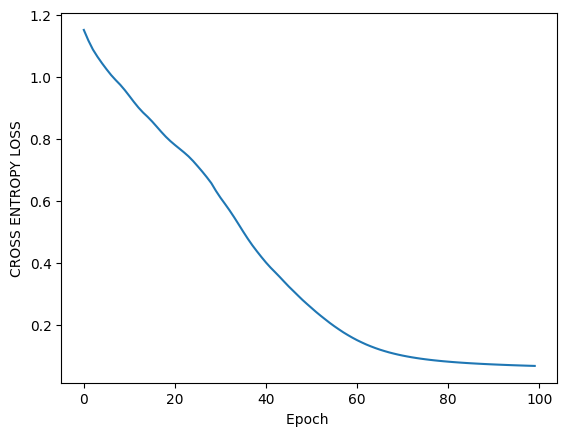

In [15]:
with torch.no_grad(): # deactivates the auto gradient engine
  plt.plot(range(epochs),losses)
  plt.ylabel('CROSS ENTROPY LOSS')
  plt.xlabel('Epoch ')

In [16]:
with torch.no_grad():
  y_eval = model.forward(X_test)
  loss = criterion(y_eval, y_test)

In [17]:
loss

tensor(0.0581)

In [18]:
correct = 0

with torch.no_grad():
  for i, data in enumerate(X_test):
    y_val = model.forward(data)
    # print(f'{i+1}.)   {str(y_val)}   {y_test[i]}')
    print(f'{i+1}.)   {str(y_val.argmax().item())}   {y_test[i]}')

    if y_val.argmax().item() == y_test[i]:
      correct += 1

print(f'We got {correct} correct')

1.)   1   1
2.)   1   1
3.)   0   0
4.)   1   1
5.)   2   2
6.)   2   2
7.)   0   0
8.)   0   0
9.)   2   2
10.)   2   2
11.)   2   2
12.)   0   0
13.)   2   2
14.)   1   1
15.)   2   2
16.)   1   1
17.)   2   2
18.)   0   0
19.)   1   1
20.)   2   2
21.)   0   0
22.)   0   0
23.)   2   2
24.)   0   0
25.)   2   2
26.)   2   2
27.)   1   1
28.)   1   1
29.)   2   2
30.)   2   2
We got 30 correct


In [19]:
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('model_scripted.pth') # Save

In [20]:
model_j = torch.jit.load('model_scripted.pth')
model_j.eval()

RecursiveScriptModule(
  original_name=Model
  (fc1): RecursiveScriptModule(original_name=Linear)
  (fc2): RecursiveScriptModule(original_name=Linear)
  (out): RecursiveScriptModule(original_name=Linear)
)

In [21]:
mystery_iris = torch.tensor([5.6,3.7,2.2,0.5])

In [22]:
with torch.no_grad():
  print(model(mystery_iris))
  print(model(mystery_iris).argmax().item())

tensor([  5.9522,   1.5596, -10.0054])
0


In [23]:
with torch.no_grad():
  # print(new_model(X_test))
  # print(new_model(X_test).argmax())

  for i, data in enumerate(model(X_test)):

  # print(f'{i+1}.)   {str(y_val)}   {y_test[i]}')
    print(f'{i+1}.)   {str(data.argmax().item())}')

1.)   1
2.)   1
3.)   0
4.)   1
5.)   2
6.)   2
7.)   0
8.)   0
9.)   2
10.)   2
11.)   2
12.)   0
13.)   2
14.)   1
15.)   2
16.)   1
17.)   2
18.)   0
19.)   1
20.)   2
21.)   0
22.)   0
23.)   2
24.)   0
25.)   2
26.)   2
27.)   1
28.)   1
29.)   2
30.)   2


In [24]:
# saves only weights and biases
torch.save(model.state_dict(),'my_iris_model.pt') 

In [25]:
new_model = Model() # does not know W or B
new_model.load_state_dict(torch.load('my_iris_model.pt'))

<All keys matched successfully>

In [26]:
new_model.eval()

Model(
  (fc1): Linear(in_features=4, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=9, bias=True)
  (out): Linear(in_features=9, out_features=3, bias=True)
)

In [27]:
torch.save(model,'my_iris_model.pth') 

In [28]:
new_model = torch.load('my_iris_model.pth')

In [29]:
new_model.eval()

Model(
  (fc1): Linear(in_features=4, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=9, bias=True)
  (out): Linear(in_features=9, out_features=3, bias=True)
)

In [30]:
mystery_iris = torch.tensor([5.6,3.7,2.2,0.5])

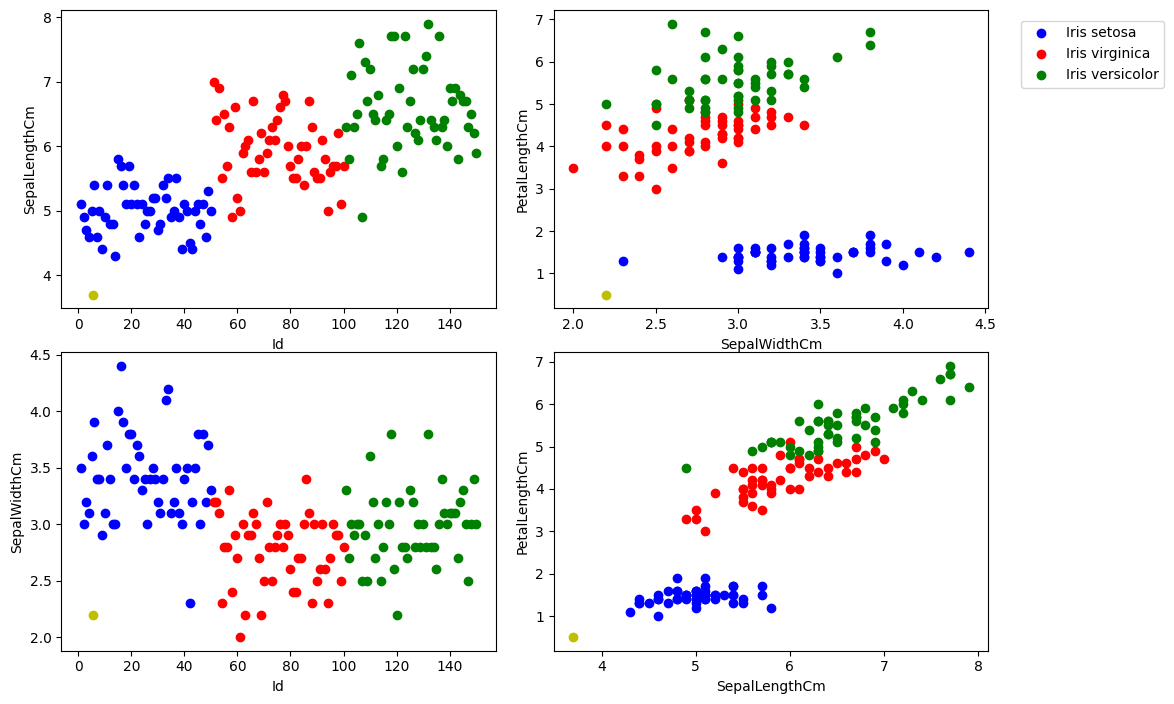

In [31]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,7))
fig.tight_layout()

plots = [(0,1),(2,3),(0,2),(1,3)]
colors = ['b', 'r', 'g']
labels = ['Iris setosa','Iris virginica','Iris versicolor']

for i, ax in enumerate(axes.flat):
    for j in range(3):
        x = df.columns[plots[i][0]]
        y = df.columns[plots[i][1]]
        ax.scatter(df[df['Species']==j][x], df[df['Species']==j][y], color=colors[j])
        ax.set(xlabel=x, ylabel=y)

    # Add a plot for our mystery iris:
    ax.scatter(mystery_iris[plots[i][0]], mystery_iris[plots[i][1]], color='y')

fig.legend(labels=labels, loc=3, bbox_to_anchor=(1.0,0.85))
plt.show()

In [32]:
with torch.no_grad():
  print(new_model(mystery_iris))
  print(new_model(mystery_iris).argmax().item())

tensor([  5.9522,   1.5596, -10.0054])
0


In [33]:
data_list = []
with torch.no_grad():
  # print(new_model(X_test))
  # print(new_model(X_test).argmax())

  for i, data in enumerate(new_model(X_test)):

  # print(f'{i+1}.)   {str(y_val)}   {y_test[i]}')
    # print(f'{i+1}.)   {str(data.argmax().item())}')
    data_list.append(data.argmax().item())
data_list

[1,
 1,
 0,
 1,
 2,
 2,
 0,
 0,
 2,
 2,
 2,
 0,
 2,
 1,
 2,
 1,
 2,
 0,
 1,
 2,
 0,
 0,
 2,
 0,
 2,
 2,
 1,
 1,
 2,
 2]

In [34]:
data_series = pd.Series(data_list) 

In [35]:
X_test_d = pd.DataFrame(X_test, columns=X.columns)
X_test_d

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,5.7,2.9,4.2,1.3
1,6.7,3.1,4.4,1.4
2,4.7,3.2,1.6,0.2
3,6.5,2.8,4.6,1.5
4,6.1,2.6,5.6,1.4
...,...,...,...,...
25,6.2,2.8,4.8,1.8
26,6.1,3.0,4.6,1.4
27,6.1,2.8,4.0,1.3
28,6.5,3.0,5.2,2.0


In [36]:
pred = pd.concat([X_test_d, data_series], axis=1)

In [37]:
pred.rename({0: 'predictions'}, axis=1, inplace=True)
pred

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,predictions
0,5.7,2.9,4.2,1.3,1
1,6.7,3.1,4.4,1.4,1
2,4.7,3.2,1.6,0.2,0
3,6.5,2.8,4.6,1.5,1
4,6.1,2.6,5.6,1.4,2
...,...,...,...,...,...
25,6.2,2.8,4.8,1.8,2
26,6.1,3.0,4.6,1.4,1
27,6.1,2.8,4.0,1.3,1
28,6.5,3.0,5.2,2.0,2


In [38]:
from Notebook.DSNotebook.NotebookExecutor import NotebookExecutor
nb = NotebookExecutor()
nb.mysql_writer('qateam', 'Temz6a52iud67', 'db.dev.bdb.ai', '3306', 'qa_test', 'iris_pred', pred)

Dataframe has been written to database.
